# Digit classifier

This notebook implements a digit classifier of 3's and 7's using different methodologies.

In [133]:
from fastai.data.external import untar_data, URLs

In [134]:
path = untar_data(URLs.MNIST_SAMPLE)

In [135]:
import numpy as np
import pandas as pd
import torch

from fastai.vision.all import Image


threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()

img_path = threes[0]
img = Image.open(img_path)
img_t = torch.tensor(np.array(img))
img_df = pd.DataFrame(img_t[2:26, 4:21])
display(img, np.array(img)[10:20, 10:20], img_t[10:20, 10:20], img_df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys'))

array([[  0,   0,   0,  24, 209, 254, 254, 254, 171,   0],
       [  0,   0,  91, 137, 253, 254, 254, 254, 112,   0],
       [ 40, 214, 250, 254, 254, 254, 254, 254,  34,   0],
       [ 81, 247, 254, 254, 254, 254, 254, 254, 146,   0],
       [  0, 110, 246, 254, 254, 254, 254, 254, 171,   0],
       [  0,   0,  73,  89,  89,  93, 240, 254, 171,   0],
       [  0,   0,   0,   0,   0,   1, 128, 254, 219,  31],
       [  0,   0,   0,   0,   0,   7, 254, 254, 214,  28],
       [  0,   0,   0,   0,   0, 138, 254, 254, 116,   0],
       [  0,   0,   0,   0,  25, 240, 254, 254,  34,   0]], dtype=uint8)

tensor([[  0,   0,   0,  24, 209, 254, 254, 254, 171,   0],
        [  0,   0,  91, 137, 253, 254, 254, 254, 112,   0],
        [ 40, 214, 250, 254, 254, 254, 254, 254,  34,   0],
        [ 81, 247, 254, 254, 254, 254, 254, 254, 146,   0],
        [  0, 110, 246, 254, 254, 254, 254, 254, 171,   0],
        [  0,   0,  73,  89,  89,  93, 240, 254, 171,   0],
        [  0,   0,   0,   0,   0,   1, 128, 254, 219,  31],
        [  0,   0,   0,   0,   0,   7, 254, 254, 214,  28],
        [  0,   0,   0,   0,   0, 138, 254, 254, 116,   0],
        [  0,   0,   0,   0,  25, 240, 254, 254,  34,   0]], dtype=torch.uint8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0,0
3,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0,0
4,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0,0
5,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0,0
6,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0,0
7,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0,0
8,0,0,0,0,0,0,0,0,0,24,209,254,254,254,171,0,0
9,0,0,0,0,0,0,0,0,91,137,253,254,254,254,112,0,0


## Pixel similarity

A nice first baseline. Compute the average of every pixel position for all images for each group (3's and 7's). This yields averages for the values each pixel position (row, col) should have. If an unseen image pixels are near all of the pixel averages for a bucket (3 or 7) we classify it as such.

In [136]:
threes_tensors = [torch.tensor(np.array(Image.open(pth))) for pth in threes]
seven_tensors = [torch.tensor(np.array(Image.open(pth))) for pth in sevens]

len(threes_tensors), len(seven_tensors)

(6131, 6265)

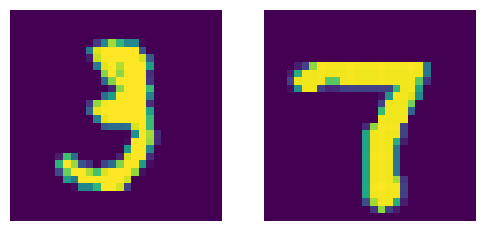

In [137]:
from fastai.data.all import show_images


show_images([threes_tensors[0], seven_tensors[0]])

In [138]:
stacked_threes = torch.stack(threes_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255

# The length of a tensor.shape is its rank!
# len(stacked_threes.shape) or stacked_threes.ndim
display(stacked_threes.shape, stacked_threes.ndim)

torch.Size([6131, 28, 28])

3

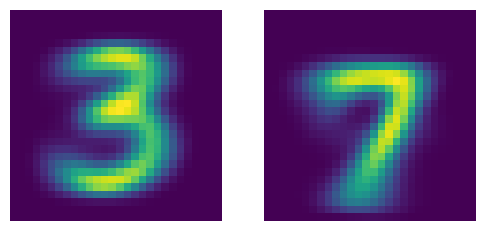

In [139]:
three_mean = stacked_threes.mean(0)
seven_mean = stacked_sevens.mean(0)

show_images([three_mean, seven_mean])

Now we can compute either the Mean-Absolute-Error (MAE or L1 norm) or the Root-Mean-Squared-Error (RMSE or L2 norm) between any given image and the previously computed mean footprint.

In [140]:
mae_three = (stacked_threes[0] - three_mean).abs().mean()
rmse_three = ((stacked_threes[0] - three_mean) ** 2).mean().sqrt()
mae_seven = (stacked_sevens[0] - three_mean).abs().mean()
rmse_seven = ((stacked_sevens[0] - three_mean) ** 2).mean().sqrt()

display(f"MAE_3={mae_three}; MAE_7={mae_seven}")
display(f"RMSE_3={rmse_three}; RMSE_7={rmse_seven}")

'MAE_3=0.10742203146219254; MAE_7=0.1715536266565323'

'RMSE_3=0.19120194017887115; RMSE_7=0.30306190252304077'

Pytorch exposes these as "loss functions" as well:

In [141]:
import torch.nn.functional as F


display(f"MAE_3={F.l1_loss(three_mean, stacked_threes[0])}; MAE_7={F.l1_loss(three_mean, stacked_sevens[0])}")
display(f"RMSE_3={F.mse_loss(three_mean, stacked_threes[0]).sqrt()}; RMSE_7={F.mse_loss(three_mean, stacked_sevens[0]).sqrt()}")

'MAE_3=0.10742203146219254; MAE_7=0.1715536266565323'

'RMSE_3=0.19120194017887115; RMSE_7=0.30306190252304077'

Now, let's extract and build the validation sets to compute the accuracy of the model to see how it performs on unseen data.

In [142]:
validation_threes = torch.stack([torch.tensor(np.array(Image.open(img_path))) for img_path in (path/"valid"/"3").ls()]).float() / 255
validation_sevens = torch.stack([torch.tensor(np.array(Image.open(img_path))) for img_path in (path/"valid"/"7").ls()]).float() / 255

display(validation_threes.shape, validation_sevens.shape)

torch.Size([1010, 28, 28])

torch.Size([1028, 28, 28])

We want to compute the Mean-Absolute-Error between the ideal 3's and 7's using the mean tensors for each and write a `is_3` method to classify any random image based on the smallest difference calculated.

In [149]:
def mnist_distance(a, b):
  return (a - b).abs().mean((-1, -2))


def is_3(img):
  return mnist_distance(img, three_mean) < mnist_distance(img, seven_mean)


is_3(validation_threes[0]), is_3(validation_sevens[0])

(tensor(True), tensor(False))

Now we can compute the accuracy by applying `is_3` to the entire validation set and getting the mean...

In [157]:
accuracy_threes = is_3(validation_threes).float().mean()
accuracy_sevens = (1 - is_3(validation_sevens).float()).mean()

accuracy_threes, accuracy_sevens, (accuracy_threes + accuracy_sevens) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))